# Musical Bootstrap

**Fitting procedure**: To fit each distribution, we follow the method outlined in Clauset et al. 2009. We use maximum likelihood estimation to estimate the parameters of each distribution, and we select the lower bound $x_{min}$ by minimizing the KS distance between the cdf of the hypothesized model and the emprical cdf. We also test goodness-of-fit without setting a lower bound $x_{min}$.

**Bootstraping procedure**: We also follow Clauset et al.'s method to bootstrap. We use their semi-parametric approach when building synthetic data sets. With probability $ p = {n_{tail}}/{n}$, we sample from the hypothesized model and with probability $1 - p$, we sample from the empirical distribution below $x_{min}$. Our $p$-values are calculated as the proportion of synthetic statistics that are greater than the fit statistic.

The bootstrap code can be found in `bootstrap.py` and the distribution fitting code, which is called by `bootstrap.py`, can be found in `distributions.py`.

---

## Summary

The following $p$-values are calculated as the proportion of synthetic $D$ statistics that are greater than the empirical $D$, where $D$ is the KS distance between the hypothesized model and the empirical distribution.

### Rhythmic bigrams

#### No $x_{min}$

| Distribution |$p_D$ |
| :-  | :-:|
| power-law | 0.000 |
| lognormal   | 0.000 |
|positive lognormal | 0.000 |
| stretched exponential  | 0.000 |
| exponential   | 0.000 ||
| power-law with cutoff  | 0.000|

#### Estimating $x_{min}$ by minimizing KS 

| Distribution | $x_{min}$ | % of data above $x_{min}$ |$p_D$ |
| :- | :-: | :-: | :-:|
| power-law | 7 | 10.57 | 0.000 |
| lognormal | 10 | 5.61 | 0.000 |
| positive lognormal | 10 | 5.61 | 0.001 |
| stretched exponential | 10 | 5.61 | 0.000 |
| exponential | 26 | 1.29 | 0.044 ||
| power-law with cutoff | 10 | 5.61 | 0.000*|

*100 iterations completed at time of writing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('dark')

In [2]:
rhythm = pd.read_csv('../data/rhythm_ranks.csv')['ranks']

In [3]:
def plot_ecdf(fit, pdf_base_function):
    fig, ax = plt.subplots(figsize=(10, 6))
    n, bins, patches = ax.hist(fit.data, len(np.unique(fit.data)), density=True, histtype='step',
                               cumulative=True, label='Empirical', color='k')
    y = pdf_base_function(bins)
    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Theoretical \n D = %.3f' % dist.D)

    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Theoretical and empircal CDF')
    ax.set_xlabel('relative bigram rank')
    ax.set_ylabel('P(X <= x)')

    plt.show()

In [4]:
def print_params(dist):
    print('Fit parameters:')
    print('\t xmin =', dist.xmin)
    for param, param_name in zip(dist.get_parameters(), dist.get_parameter_names()):
        print('\t %s =' % param_name, param)
    print('\t D =', dist.D)

In [5]:
def get_p_values(dist, bootstrap):
    print('p-values:')
    p = len(list(filter(lambda x: x > dist.D, bootstrap['D'])))/len(bootstrap)
    print('\t p_D = %.4f' % p)
    p = len(list(filter(lambda x: x > dist.xmin, bootstrap['xmin'])))/len(bootstrap)
    print('\t p_xmin =', p)
    for param, param_name in zip(dist.get_parameters(), dist.get_parameter_names()):
        p = len(list(filter(lambda x: x > param, bootstrap[param_name])))/len(bootstrap)
        print('\t p_%s =' % param_name, p)

In [49]:
def plot_bootstrap(dist, boot, bin_norm=30):
    fig, axs = plt.subplots(2, 2, figsize=(9, 11))
    N, bins, patches = axs[0, 0].hist(boot.xmin, 
                                      bins=20 if len(np.unique(boot.xmin)) == 1 else len(np.unique(boot.xmin)), 
                                     label='mean = %.3f\nstd = %.3f' % (np.mean(boot.xmin), np.std(boot.xmin)))
    axs[0,0].set(ylabel='frequency')
    axs[0,0].grid(True)
    axs[0, 0].set_title('x_min')
    axs[0, 0].legend()
    N, bins, patches = axs[0,1].hist(boot.D, bins=int(len(np.unique(boot.D))/bin_norm), 
                                     label='mean = %.3f\nstd = %.3f' % (np.mean(boot.D), np.std(boot.D)))
    axs[0, 1].set_title('D')
    axs[0,1].grid(True)
    axs[0,1].legend()
    params = dist.get_parameters()
    names = dist.get_parameter_names()
    i = 0 
    for n,p in zip(names, params):
        N, bins, patches = axs[1, i].hist(boot[n], bins=int(len(np.unique(boot[n]))/bin_norm),
                                         label='mean = %.3f\nstd = %.3f' % (np.mean(boot[n]), np.std(boot[n])))
        axs[1, i].set_title(n)
        axs[1,i].grid(True)
        axs[1,i].legend()
        if i == 1:
            axs[1,i].set(xlabel='estimate')
        else:
            axs[1,i].set(xlabel='estimate', ylabel='frequency')
        i+=1
    if i == 1: 
        axs[0, 1].set(xlabel='estimate')
        fig.delaxes(axs[1,1])
    st = fig.suptitle('Bootstrap parameter estimate histograms')   
    #fig.tight_layout()
    st.set_y(0.90)
    fig.subplots_adjust(top=0.85)

In [50]:
def get_local_minima(dist):    
    Ds = dist.Ds
    Ds.sort(key=lambda l: l[1])
    Ds = [d[-1] for d in Ds]
    return [i+1 for i in range(1,len(Ds)-1) if Ds[i-1] > Ds[i] and Ds[i+1] > Ds[i]]

In [51]:
from distributions import Exponential, Lognormal, Stretched_exponential, Powerlaw_with_cutoff, Powerlaw, Positive_lognormal

---

Text(0.5, 1.0, 'Histrogram of rhythmic bigram ranks')

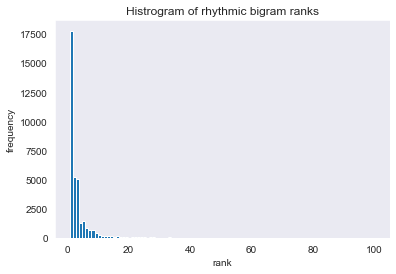

In [52]:
n = plt.hist(rhythm, bins=len(np.unique(rhythm)))
plt.xlabel('rank')
plt.ylabel('frequency')
plt.title('Histrogram of rhythmic bigram ranks')

----
## Exponential

In [53]:
exp_noxmin = pd.read_csv('bootstrap_data/rhythm_exp_bootstrap_1e3_xmin1.csv')

In [54]:
dist = Exponential(rhythm, xmin=1) # "no xmin"

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [55]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 lambda = 0.35644951502287137
	 D = 0.20527174495647432


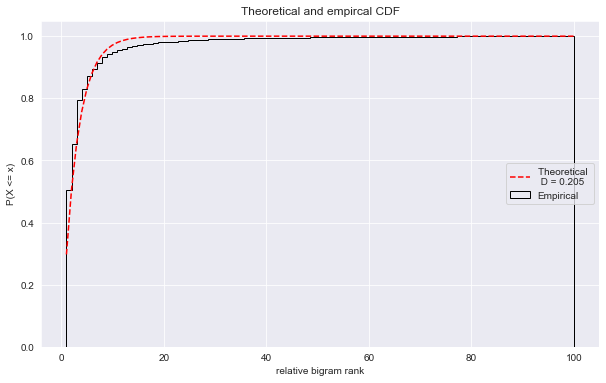

In [56]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [57]:
get_p_values(dist,exp_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_lambda = 0.495


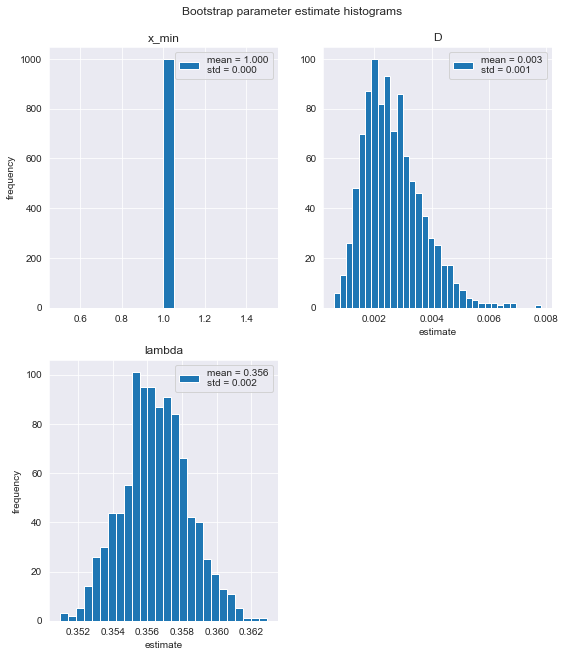

In [58]:
plot_bootstrap(dist, exp_noxmin)

In [59]:
# estimating an xmin
exp_ = pd.read_csv('bootstrap_data/rhythm_exp_bootstrap_1e3.csv')

In [60]:
# using min KS value as estimate for xmin
dist = Exponential(rhythm)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [61]:
print_params(dist)

Fit parameters:
	 xmin = 26.0
	 lambda = 0.0509221922627453
	 D = 0.0365084719829577


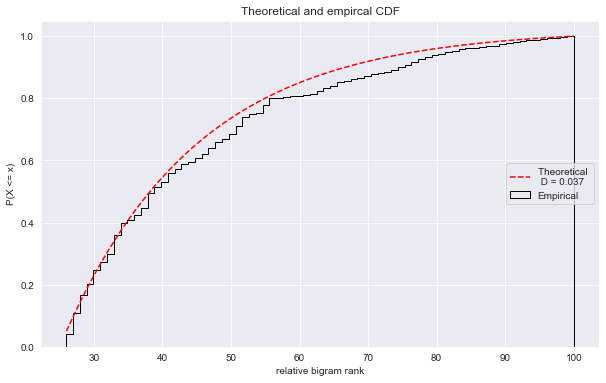

In [62]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [63]:
get_p_values(dist, exp_)

p-values:
	 p_D = 0.0440
	 p_xmin = 0.565
	 p_lambda = 0.513


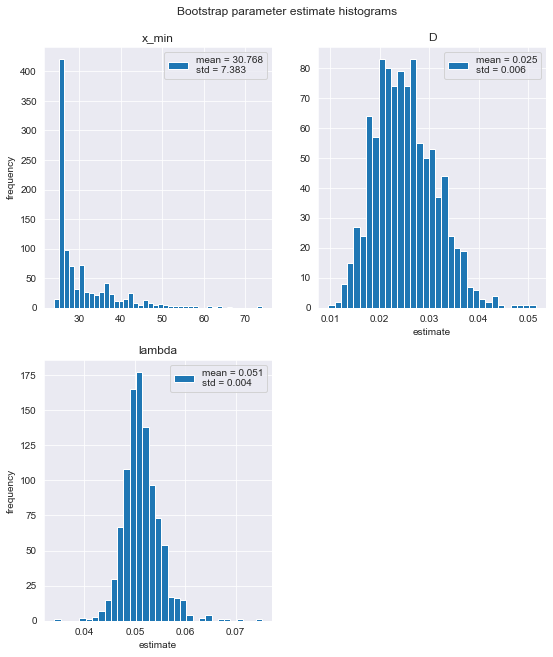

In [64]:
plot_bootstrap(dist, exp_)

---
## Lognormal

In [65]:
lognormal_boot_noxmin = pd.read_csv('bootstrap_data/rhythm_ln_bootstrap_1e3_xmin1.csv')

In [66]:
# fit data to lognormal
dist = Lognormal(rhythm, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


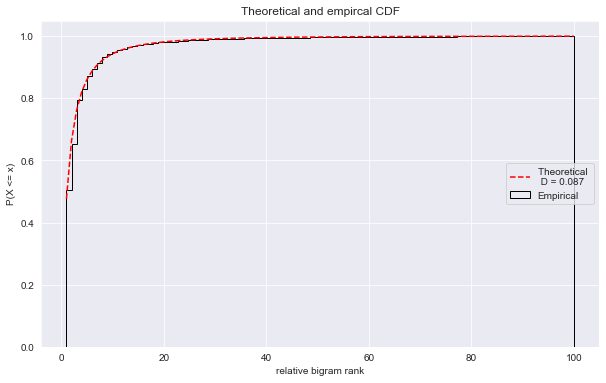

In [67]:
plot_ecdf(dist, dist.fit.lognormal._pdf_base_function)

In [68]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 mu = -0.4687793121182675
	 sigma = 1.5014590384151016
	 D = 0.08668015528185985


In [69]:
get_p_values(dist, lognormal_boot_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_mu = 1.0
	 p_sigma = 0.0


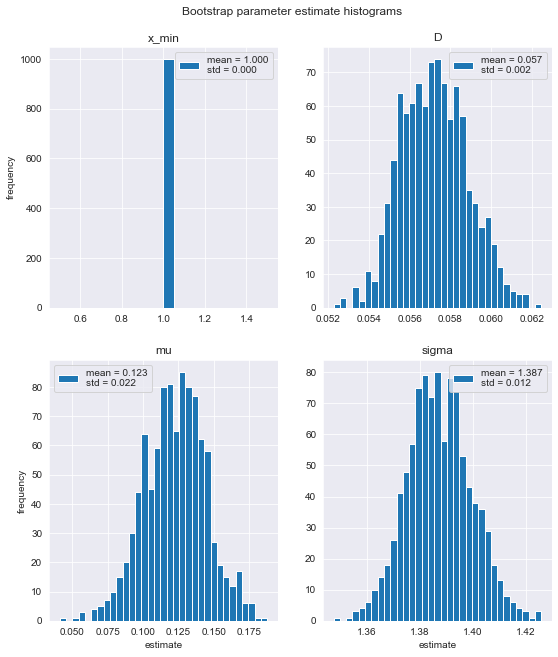

In [70]:
plot_bootstrap(dist, lognormal_boot_noxmin)

In [71]:
lognormal_boot = pd.read_csv('bootstrap_data/rhythm_ln_bootstrap_1e3.csv')

In [72]:
dist = Lognormal(rhythm)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:1560: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


In [73]:
print_params(dist)

Fit parameters:
	 xmin = 10.0
	 mu = 1.6384335890876973
	 sigma = 1.0698522651377917
	 D = 0.025010644626544565


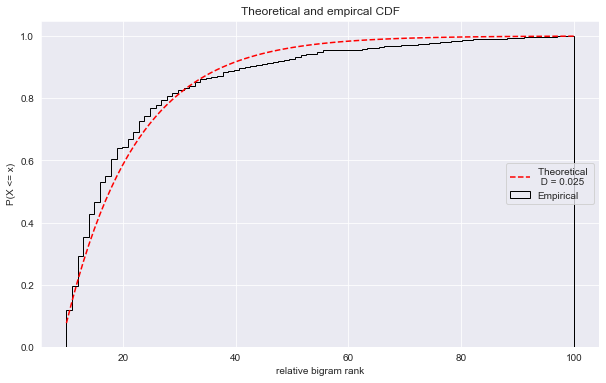

In [74]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [75]:
get_p_values(dist, lognormal_boot)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.631
	 p_mu = 0.621
	 p_sigma = 0.414


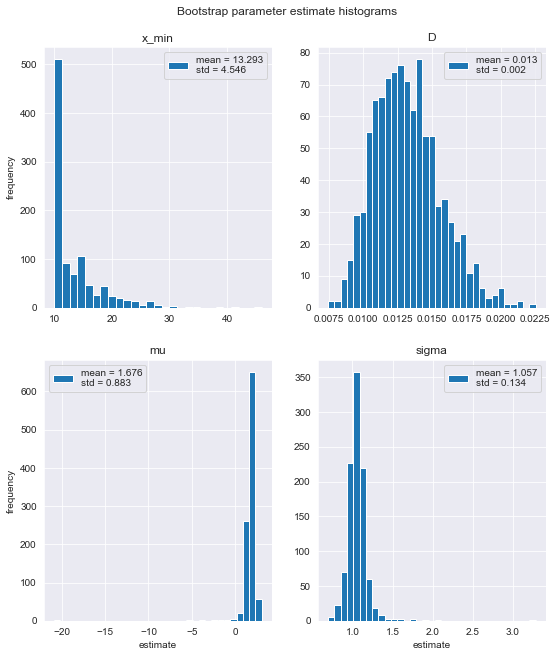

In [76]:
plot_bootstrap(dist, lognormal_boot)

## Positive lognormal

In [104]:
pos_ln_noxmin = pd.read_csv('bootstrap_data/rhythm_pos_ln_bootstrap_1e3_xmin1.csv')

In [105]:
dist = Positive_lognormal(rhythm,xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [106]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 mu = 1.5259974417353926e-07
	 sigma = 1.2972051146401165
	 D = 0.0982210218800274


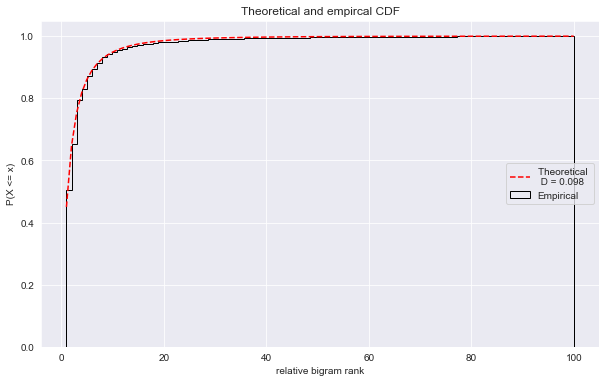

In [107]:
plot_ecdf(dist, dist.fit.lognormal_positive._pdf_base_function)

In [108]:
get_p_values(dist, pos_ln_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_mu = 1.0
	 p_sigma = 0.0


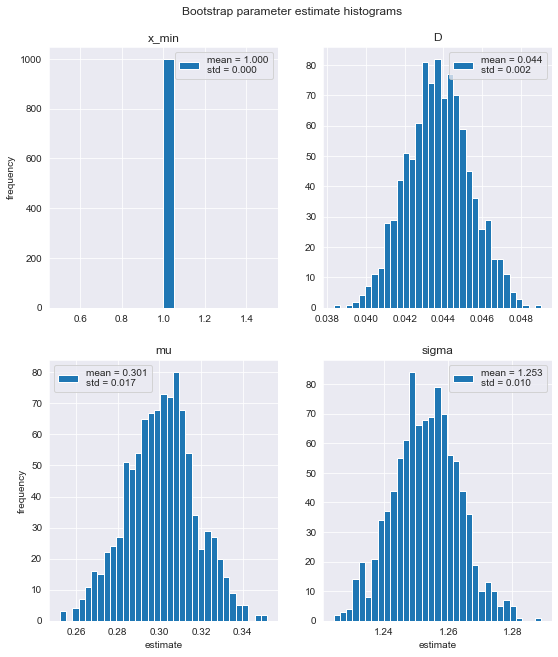

In [109]:
plot_bootstrap(dist, pos_ln_noxmin)

In [110]:
pos_ln = pd.read_csv('bootstrap_data/rhythm_pos_ln_bootstrap_1e3.csv')

In [111]:
dist = Positive_lognormal(rhythm)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:1560: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


In [112]:
print_params(dist)

Fit parameters:
	 xmin = 10.0
	 mu = 1.6384335890876973
	 sigma = 1.0698522651377917
	 D = 0.025010644626544565


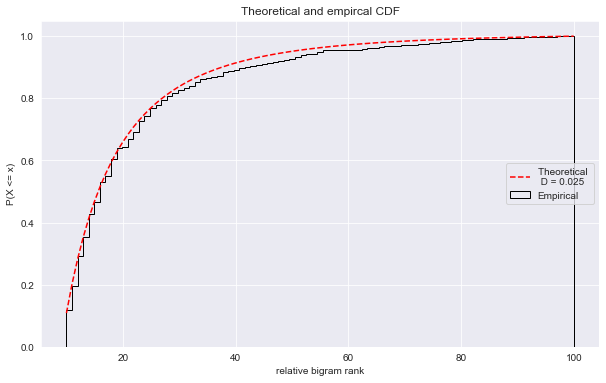

In [113]:
plot_ecdf(dist, dist.fit.lognormal_positive._pdf_base_function)

In [114]:
get_p_values(dist, pos_ln)

p-values:
	 p_D = 0.0010
	 p_xmin = 0.631
	 p_mu = 0.633
	 p_sigma = 0.408


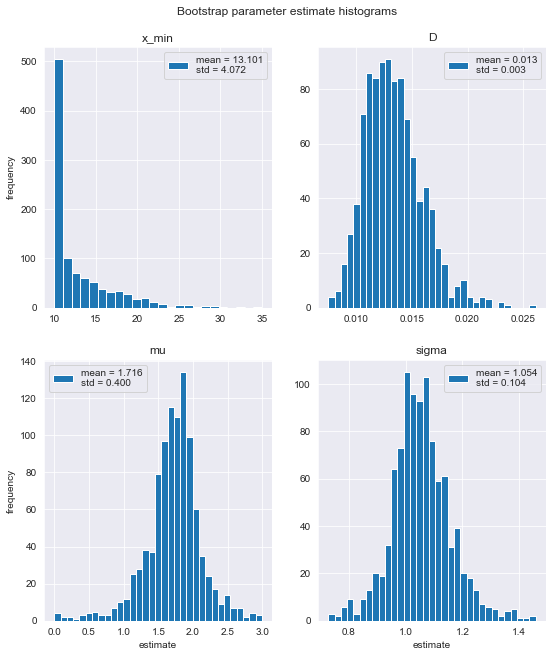

In [115]:
plot_bootstrap(dist, pos_ln)

## Stretched exponential

In [77]:
str_exp_noxmin = pd.read_csv('bootstrap_data/rhythm_strexp_bootstrap_1e3_xmin1.csv')

In [78]:
dist = Stretched_exponential(rhythm, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [79]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 lambda = 6.171936045954935
	 beta = 0.3533899998094566
	 D = 0.09580093102606024


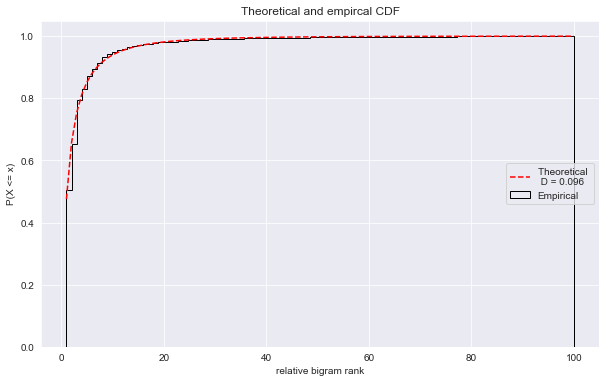

In [80]:
plot_ecdf(dist, dist.fit.stretched_exponential._pdf_base_function)

In [81]:
get_p_values(dist, str_exp_noxmin)

p-values:
	 p_D = 0.0010
	 p_xmin = 0.0
	 p_lambda = 0.0
	 p_beta = 1.0


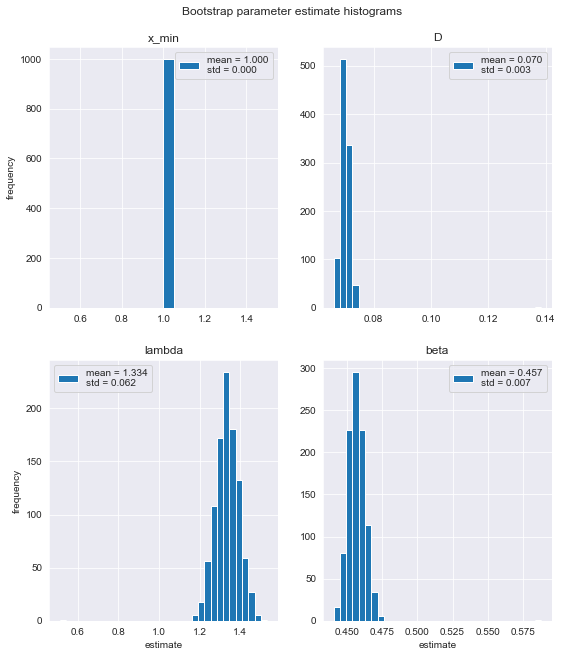

In [82]:
plot_bootstrap(dist, str_exp_noxmin)

In [83]:
str_exp_boot = pd.read_csv('bootstrap_data/rhythm_strexp_bootstrap_1e3.csv')

In [84]:
dist = Stretched_exponential(rhythm)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [85]:
print_params(dist)

Fit parameters:
	 xmin = 10.0
	 lambda = 0.7276223072349021
	 beta = 0.4632221533938963
	 D = 0.028362399385756687


In [86]:
get_p_values(dist, str_exp_boot)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.741
	 p_lambda = 0.36
	 p_beta = 0.628


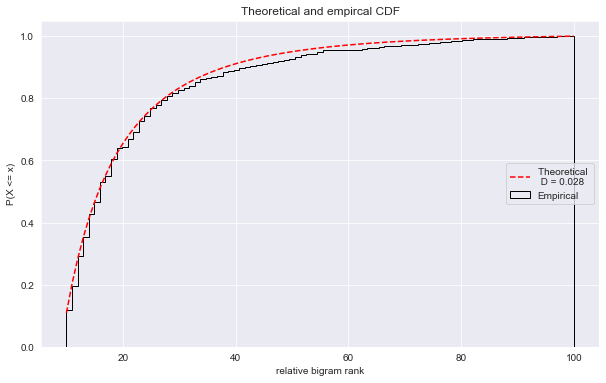

In [87]:
plot_ecdf(dist, dist.fit.stretched_exponential._pdf_base_function)

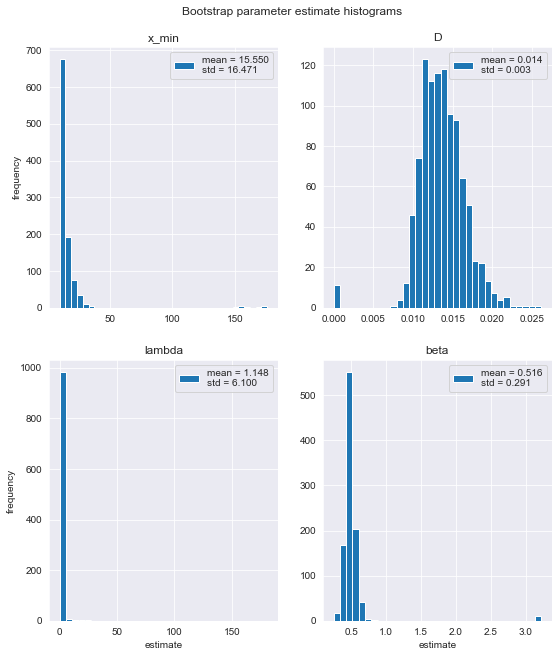

In [88]:
plot_bootstrap(dist, str_exp_boot)

----
## Power-law with cutoff

In [89]:
plcut_noxmin = pd.read_csv('bootstrap_data/rhythm_pl_co_bootstrap_1e3_xmin1.csv')

In [90]:
dist = Powerlaw_with_cutoff(rhythm, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [91]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 alpha = 1.0000000004687208
	 lambda = 0.31927434956694045
	 D = 0.07321728067317435


In [92]:
get_p_values(dist, plcut_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_alpha = 0.99
	 p_lambda = 0.0


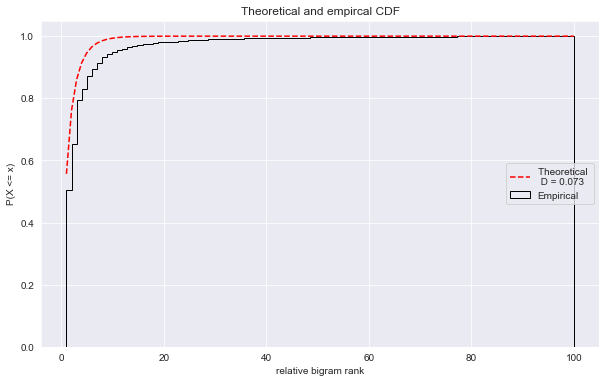

In [93]:
plot_ecdf(dist, dist.fit.truncated_power_law._pdf_base_function)

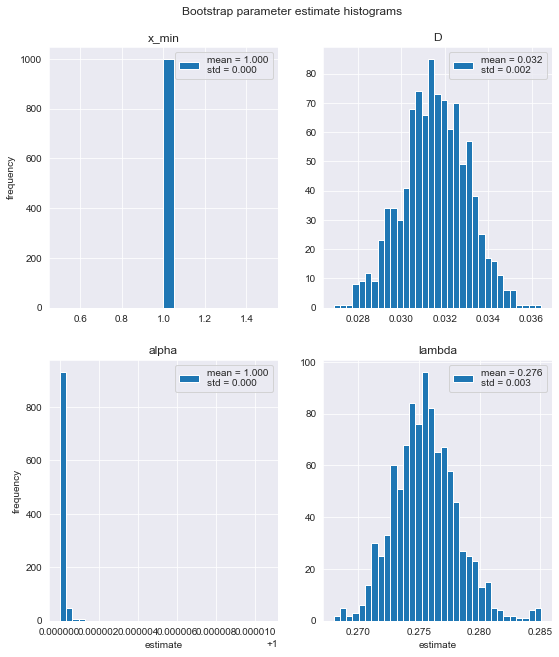

In [94]:
plot_bootstrap(dist, plcut_noxmin)

In [95]:
# Note: only 100 iterations
plcut = pd.read_csv('bootstrap_data/rhythm_pl_cut_bootstrap_1e3.csv')

In [96]:
dist = Powerlaw_with_cutoff(rhythm)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [97]:
print_params(dist)

Fit parameters:
	 xmin = 10.0
	 alpha = 1.6082104247664817
	 lambda = 0.026034529075347316
	 D = 0.027118427495990916


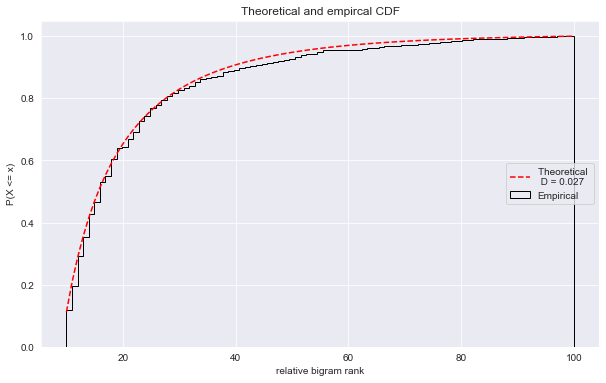

In [98]:
plot_ecdf(dist, dist.fit.truncated_power_law._pdf_base_function)

In [99]:
get_p_values(dist, plcut)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.8
	 p_alpha = 0.29
	 p_lambda = 0.61


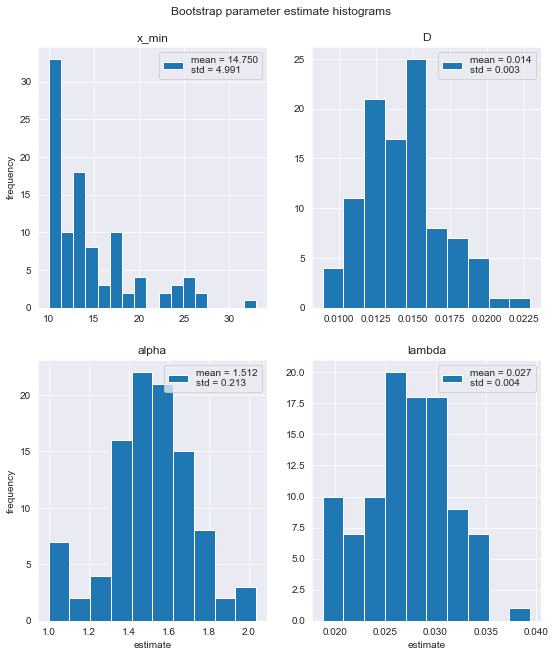

In [100]:
plot_bootstrap(dist, plcut, bin_norm=10)

## Power-law

In [117]:
pl_boot = pd.read_csv('bootstrap_data/rhythm_pl_bootstrap_1e3.csv')

In [118]:
dist = Powerlaw(rhythm)

Calculating best minimal value for power law fit
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [119]:
print_params(dist)

Fit parameters:
	 xmin = 7.0
	 alpha = 2.5544913139535845
	 D = 0.026632742514078184


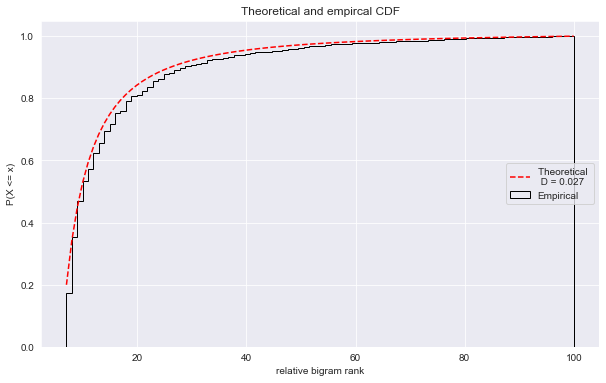

In [120]:
plot_ecdf(dist, dist.fit.power_law._pdf_base_function)

In [121]:
get_p_values(dist, pl_boot)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.391
	 p_alpha = 0.358


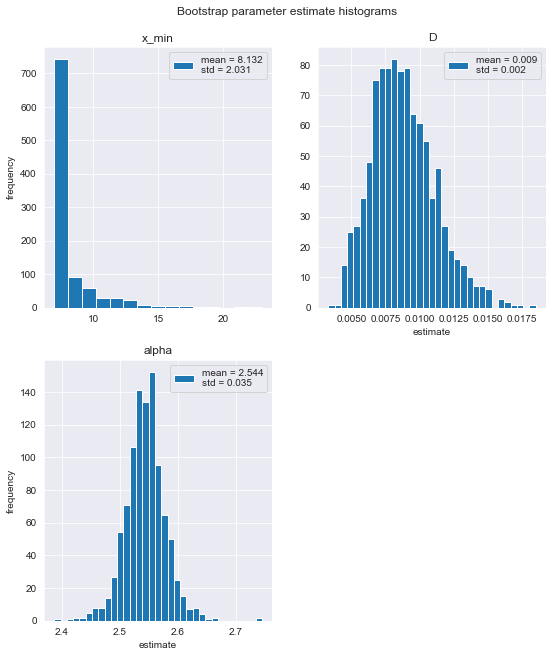

In [122]:
plot_bootstrap(dist, pl_boot)